<br><font size="8">Vinicius Caridá<br><br><strong>AutoEncoders</strong></font>



# O que são AutoEncoders e para que servem?

O que são:
![](http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png)

Para que servem:
* ~~Compressão de Dados~~
* Redução de Dimensionalidade e [Semantic Hashing](http://www.cs.toronto.edu/~amnih/cifar/talks/salakhut_talk.pdf)
* É base para arquiteturas campeãs em Segmentação de Imagens como as [U-NETs](https://image.slidesharecdn.com/dlsl2017d2l6advanceddeeparchitectures-170125171011/95/advanced-deep-architectures-d2l6-deep-learning-for-speech-and-language-upc-2017-17-638.jpg?cb=1485364567)...
* [Detecção de Anomalias](https://shiring.github.io/machine_learning/2017/05/01/fraud) e [Fraudes em Cartões de Crédito](https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd)
* Modelos Generativos para imagens com controle do "o quê" e do "como" é gerado - com [Varational Auto Encoders](http://kvfrans.com/variational-autoencoders-explained/)
* Eliminar Ruídos - A gente tem um exemplo aqui.

# Importando as bibliotecas

In [1]:
import numpy as np
np.random.seed(0)

In [2]:
from keras import backend as K
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.datasets import mnist
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Explorando o Conjunto de Dados

Vamos usar o dataset do [MNIST](https://www.tensorflow.org/get_started/mnist/beginners)

In [4]:
(x_train_orig, _), (x_test_orig, _) = mnist.load_data()

In [5]:
x_train_orig.shape, x_test_orig.shape

((60000, 28, 28), (10000, 28, 28))

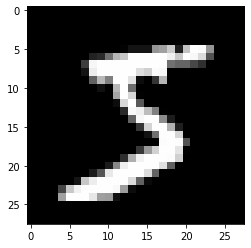

In [6]:
plt.imshow(x_train_orig[0], cmap='Greys_r')

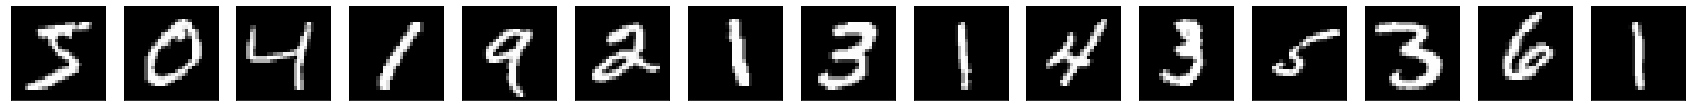

In [7]:
n = 15  # how many digits we will display
plt.figure(figsize=(n*2, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train_orig[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
img = x_train_orig[0]
img.min(), img.max()

(0, 255)

### Escalando os dados

In [9]:
x_train_orig = x_train_orig.astype('float32') / 255.
x_test_orig = x_test_orig.astype('float32') / 255.

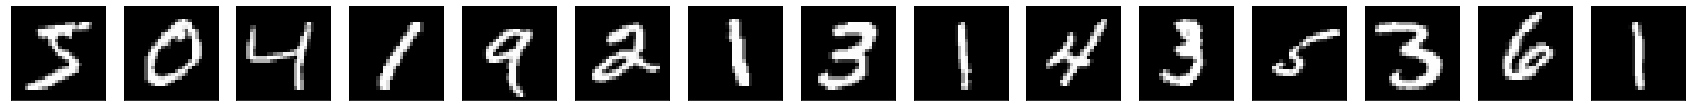

In [10]:
n = 15  # how many digits we will display
plt.figure(figsize=(n*2, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train_orig[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
img = x_train_orig[0]
img.min(), img.max()

(0.0, 1.0)

### Adicionando ruído ao dataset

In [12]:
noise_factor = 0.5
x_train_noisy = np.clip(x_train_orig + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_orig.shape), 0, 1)
x_test_noisy = np.clip(x_test_orig + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_orig.shape), 0, 1)

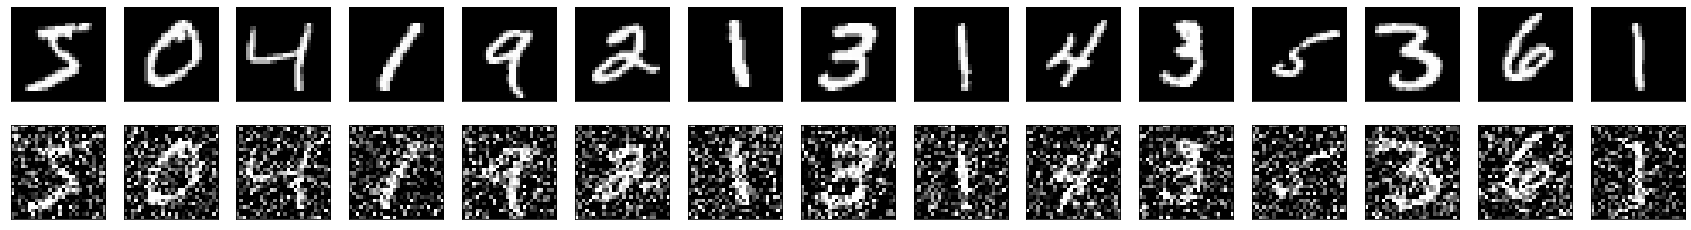

In [13]:
n = 15  # how many digits we will display
plt.figure(figsize=(n*2, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train_orig[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display noisy
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_train_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
x_train_orig.shape, x_train_noisy.shape

((60000, 28, 28), (60000, 28, 28))

### Transformando Cada imagem de 28 x 28 em um vetor de 784 

In [15]:
x_train = x_train_orig.reshape((len(x_train_orig), np.prod(x_train_orig.shape[1:])))
x_test = x_test_orig.reshape((len(x_test_orig), np.prod(x_test_orig.shape[1:])))

In [16]:
x_train.shape

(60000, 784)

In [17]:
x_train_conv = x_train_orig.reshape(-1,28,28,1)
x_test_conv = x_test_orig.reshape(-1,28,28,1)
x_train_noisy_conv = x_train_noisy.reshape(-1,28,28,1)
x_test_noisy_conv = x_test_noisy.reshape(-1,28,28,1)

In [18]:
x_train_conv.shape

(60000, 28, 28, 1)

# Modelo 1: Fully Connected Neural Network de Apenas 1 camada

![](https://www.researchgate.net/publication/318204554/figure/fig1/AS:512595149770752@1499223615487/Fig-1-Autoencoder-architecture.png)

In [19]:
encoding_dim = 32
image_dim = x_train.shape[1]

In [20]:
image_dim

784

In [21]:
input_img = Input(shape=(image_dim,))

In [22]:
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(image_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
encoder = Model(input_img, encoded)

In [24]:
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [25]:
# carregando o modelo, se necessário
#autoencoder.load_weights('checkpoint_modelo_1.hdf5')

In [26]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [27]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [28]:
#teste error
#import tensorflow as tf
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

#tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)
           

In [29]:
checkpointer_1 = ModelCheckpoint(filepath='checkpoint_modelo_1.hdf5', verbose=1, save_best_only=True)

In [30]:
history_model_1 = autoencoder.fit(x_train, x_train,
                                  epochs=10,
                                  batch_size=256,
                                  shuffle=True,
                                  validation_data=(x_test, x_test),
                                  callbacks=[checkpointer_1])

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10


InternalError: Blas GEMM launch failed : a.shape=(256, 784), b.shape=(784, 32), m=256, n=32, k=784
	 [[{{node dense_1/MatMul}}]]
	 [[{{node loss/mul}}]]

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
n = 15  # how many digits we will display
plt.figure(figsize=(2*n, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Grafico do treinamento
plt.plot(history_model_1.history['loss'], 'b')
plt.plot(history_model_1.history['val_loss'], 'r')
plt.show()

# Modelo 2: Fully Connected Neural Network de Apenas 1 camada com Regularização L1

Os regularizadores permitem aplicar penalidades nos parâmetros do layer durante a etapa de otimização. As penalidades são incorporadas na função de custo que a rede otimiza.

In [ ]:
input_img = Input(shape=(image_dim,))

encoded_reg = Dense(32, activation='relu', activity_regularizer=regularizers.l1(5*10e-8))(input_img)
decoded_reg = Dense(784, activation='sigmoid')(encoded_reg)

autoencoder_reg = Model(input_img, decoded_reg)

In [ ]:
# carregando o modelo, se necessário
#autoencoder.load_weights('checkpoint_modelo_2.hdf5')

In [ ]:
autoencoder_reg.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder_reg.summary()

O modelo com regularização geralmente é menos passível de _overfitting_ e pode ser treinado por mais tempo. 

In [ ]:
checkpointer_2 = ModelCheckpoint(filepath='checkpoint_modelo_2.hdf5', verbose=1, save_best_only=True)

In [ ]:
history_model_2 = autoencoder_reg.fit(x_train, x_train,
                                    epochs=10,
                                    batch_size=256,
                                    shuffle=True,
                                    validation_data=(x_test, x_test),
                                    callbacks=[checkpointer_2])

In [ ]:
# Grafico do treinamento
plt.plot(history_model_2.history['loss'], 'b')
plt.plot(history_model_2.history['val_loss'], 'r')
plt.show()

In [ ]:
encoder_reg = Model(input_img, encoded_reg)

In [ ]:
#encoded_input = Input(shape=(encoding_dim,))
decoder_layer_reg = autoencoder_reg.layers[-1]
decoder_reg = Model(encoded_input, decoder_layer_reg(encoded_input))

In [ ]:
encoded_imgs_reg = encoder_reg.predict(x_test)
decoded_imgs_reg = decoder_reg.predict(encoded_imgs_reg)

In [ ]:
n = 15  # how many digits we will display
plt.figure(figsize=(2*n, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_reg[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Não há muita diferença na função de custo... A diferença maior é que a representação das imagens _encodadas_ é mais esparsa.

In [ ]:
encoded_imgs.mean()

In [ ]:
encoded_imgs_reg.mean()

# Modelo 3: Deep Neural Network de 6 camadas Totalmente Conectadas


In [2]:
#input_img = Input(shape=(image_dim,))

encoded_deep = Dense(128, activation='relu')(input_img)
encoded_deep = Dense(64, activation='relu')(encoded_deep)
encoded_deep = Dense(32, activation='relu')(encoded_deep)

decoded_deep = Dense(64, activation='relu')(encoded_deep)
decoded_deep = Dense(128, activation='relu')(decoded_deep)
decoded_deep = Dense(784, activation='sigmoid')(decoded_deep)

autoencoder_deep = Model(input_img, decoded_deep)

NameError: name 'Dense' is not defined

In [3]:
# carregando o modelo, se necessário
#autoencoder.load_weights('checkpoint_modelo_3.hdf5')

In [ ]:
autoencoder_deep.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder_deep.summary()

In [ ]:
checkpointer_3 = ModelCheckpoint(filepath='checkpoint_modelo_3.hdf5', verbose=1, save_best_only=True)

In [ ]:
history_model_3 = autoencoder_deep.fit(x_train, x_train,
                                        epochs=10,
                                        batch_size=256,
                                        shuffle=True,
                                        validation_data=(x_test, x_test),
                                        callbacks=[checkpointer_3])

In [ ]:
# Grafico do treinamento
plt.plot(history_model_3.history['loss'], 'b')
plt.plot(history_model_3.history['val_loss'], 'r')
plt.show()

In [ ]:
encoder_deep = Model(input_img, encoded_deep)

In [ ]:
#encoded_input = Input(shape=(encoding_dim,))

decoder_layer_deep = autoencoder_deep.layers[-3]
decoder_deep = Model(encoded_input, decoder_layer_deep(encoded_input))
decoder_deep_new = Sequential()
decoder_deep_new.add(decoder_deep)
decoder_deep_new.add(autoencoder_deep.layers[-2])
decoder_deep_new.add(autoencoder_deep.layers[-1])

In [ ]:
decoded_imgs_deep = autoencoder_deep.predict(x_test)

In [ ]:
n = 15  # how many digits we will display
plt.figure(figsize=(2*n, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_deep[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Modelo 4: Deep Convolutional Network

![Convolutional AutoEncoder](https://cdn-images-1.medium.com/max/1600/1*8ixTe1VHLsmKB3AquWdxpQ.png)

In [ ]:
K.image_data_format()

In [1]:
input_img_conv = Input(shape=(28, 28, 1))

encoded_conv = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img_conv)
encoded_conv = MaxPooling2D((2, 2), padding='same')(encoded_conv)
encoded_conv = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_conv)
encoded_conv = MaxPooling2D((2, 2), padding='same')(encoded_conv)
encoded_conv = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_conv)
encoded_conv = MaxPooling2D((2, 2), padding='same')(encoded_conv)

# (4, 4, 8) => 128

decoded_conv = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_conv)
decoded_conv = UpSampling2D((2, 2))(decoded_conv)
decoded_conv = Conv2D(8, (3, 3), activation='relu', padding='same')(decoded_conv)
decoded_conv = UpSampling2D((2, 2))(decoded_conv)
decoded_conv = Conv2D(16, (3, 3), activation='relu')(decoded_conv)
decoded_conv = UpSampling2D((2, 2))(decoded_conv)
decoded_conv = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded_conv)

NameError: name 'Input' is not defined

In [ ]:
autoencoder_conv = Model(input_img_conv, decoded_conv)

In [ ]:
# carregando o modelo, se necessário
#autoencoder.load_weights('checkpoint_modelo_4.hdf5')

In [ ]:
autoencoder_conv.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder_conv.summary()

In [ ]:
checkpointer_4 = ModelCheckpoint(filepath='checkpoint_modelo_4.hdf5', verbose=1, save_best_only=True)

In [ ]:
history_model_4 = autoencoder_conv.fit(x_train_conv, x_train_conv,
                                        epochs=10,
                                        batch_size=256,
                                        shuffle=True,
                                        validation_data=(x_test_conv, x_test_conv),
                                        callbacks=[checkpointer_4])

In [ ]:
# Grafico do treinamento
plt.plot(history_model_4.history['loss'], 'b')
plt.plot(history_model_4.history['val_loss'], 'r')
plt.show()

In [ ]:
decoded_imgs_conv = autoencoder_conv.predict(x_test_conv)

In [ ]:
n = 15  # how many digits we will display
plt.figure(figsize=(2*n, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Modelo 5: Aplicação em Eliminação de Ruído

In [ ]:
input_img_conv = Input(shape=(28, 28, 1))

encoded_conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img_conv)
encoded_conv2 = MaxPooling2D((2, 2), padding='same')(encoded_conv2)
encoded_conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_conv2)
encoded_conv2 = MaxPooling2D((2, 2), padding='same')(encoded_conv2)
encoded_conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_conv2)
encoded_conv2 = MaxPooling2D((2, 2), padding='same')(encoded_conv2)

# (4, 4, 8) => 128

decoded_conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_conv2)
decoded_conv2 = UpSampling2D((2, 2))(decoded_conv2)
decoded_conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(decoded_conv2)
decoded_conv2 = UpSampling2D((2, 2))(decoded_conv2)
decoded_conv2 = Conv2D(16, (3, 3), activation='relu')(decoded_conv2)
decoded_conv2 = UpSampling2D((2, 2))(decoded_conv2)
decoded_conv2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded_conv2)



In [ ]:
autoencoder_conv_denoise = Model(input_img_conv, decoded_conv2)

In [ ]:
# carregando o modelo, se necessário
#autoencoder.load_weights('checkpoint_modelo_5_.hdf5')

In [ ]:
autoencoder_conv_denoise.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
checkpointer_5 = ModelCheckpoint(filepath='checkpoint_modelo_5_.hdf5', verbose=1, save_best_only=True)

In [ ]:
history_model_5 = autoencoder_conv_denoise.fit(x_train_noisy_conv, x_train_conv,
                                          epochs=5,
                                          batch_size=256,
                                          shuffle=True,
                                          validation_data=(x_test_noisy_conv, x_test_conv),
                                          callbacks=[checkpointer_5])

In [ ]:
# Grafico do treinamento
plt.plot(history_model_5.history['loss'], 'b')
plt.plot(history_model_5.history['val_loss'], 'r')
plt.show()

In [ ]:
decoded_imgs_conv_denoise = autoencoder_conv_denoise.predict(x_test_noisy_conv)

In [ ]:
#TAG-PREDICT: model(tira_ruido), parameter(imagem)
#def tira_ruido(imagem)
#    return autoencoder_conv_denoise.predict(imagem)

In [ ]:
n = 15  # how many digits we will display
plt.figure(figsize=(2*n, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv_denoise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Material de Referência e Consulta:
* https://github.com/udacity/deep-learning/blob/master/autoencoder/Simple_Autoencoder_Solution.ipynb
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://elitedatascience.com/keras-tutorial-deep-learning-in-python
* http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/
* https://arxiv.org/pdf/1512.09300.pdf
* https://arxiv.org/pdf/1312.6114.pdf